# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 2</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer



In [2]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

In [3]:
viviendas_caba_train_pca=pd.read_csv('./Datasets/pca_properati_argentina_2021.csv').copy()
viviendas_caba_train_pca

,Unnamed: 0,cp_1,cp_2,cp_3,cp_4
0,0,-1.014526,-1.599942,0.115596,0.349690
1,1,-1.951728,0.995390,-1.122970,1.244216
2,2,-1.439863,0.480414,-0.376037,0.506938
3,3,-1.515383,-0.357273,1.030428,0.238365
4,4,-0.428997,-0.083970,1.115435,0.190258
...,...,...,...,...,...
74366,74366,-1.149877,-1.575896,0.755568,-0.167630
74367,74367,-1.113407,-1.796706,0.202094,0.157633
74368,74368,-1.216436,-1.163836,0.391533,0.039394
74369,74369,0.127323,0.551885,-0.069652,-0.155747


# 2. Agrupamiento

### Analizar la tendencia al clustering del dataset:

In [4]:
viviendas_caba_train.head()

,Unnamed: 0,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,0,2021-11-03,2022-02-02,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.0,65.000000,53.0,198000.0,1 - Holmberg 2700,POINT (-58.4796377 -34.566536)
1,1,2021-12-03,2022-01-27,-34.645625,-58.459408,Flores,Departamento,1.0,1.0,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,POINT (-58.4594077 -34.6456246)
2,2,2021-11-16,2021-11-18,-34.616825,-58.443603,Caballito,Departamento,2.0,1.0,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,POINT (-58.44360306 -34.61682542)
3,3,2021-03-08,2021-06-05,-34.577033,-58.423367,Palermo,Departamento,1.0,1.0,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,POINT (-58.4233675 -34.5770327)
4,4,2021-01-16,2021-10-09,-34.580210,-58.412815,Palermo,Departamento,1.0,2.0,91.050087,78.0,290000.0,Departamento en Palermo,POINT (-58.412815 -34.58021)


In [5]:
datos_numericos = viviendas_caba_train.copy()
datos_numericos.drop(columns=['Unnamed: 0','start_date','end_date','barrio', 'property_title','geometry','property_type'],inplace=True)
datos_numericos.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.566536,-58.479638,2.0,1.0,65.000000,53.0,198000.0
1,-34.645625,-58.459408,1.0,1.0,29.000000,29.0,63000.0
2,-34.616825,-58.443603,2.0,1.0,41.000000,35.0,93000.0
3,-34.577033,-58.423367,1.0,1.0,49.000000,44.0,160000.0
4,-34.580210,-58.412815,1.0,2.0,91.050087,78.0,290000.0


#### ANALISIS DE TENDENCIA AL CLUSTERING

In [6]:
hopkins(datos_numericos,datos_numericos.shape[0])

0.0006683240583891352

Dado el resultado del estadistico de Hopkins, vemos que hay una muy alta tendencia al clustering, de todos modos, sabemos que el test de Hopkins se ve muy influenciado por outliers.
Volvemos a calcularlo con datos normalizados.


In [7]:
normalizado = preprocessing.normalize(datos_numericos)
hopkins(normalizado,normalizado.shape[0])


0.00042589098653676233

Si bien ya era alta, aumento aun mas la tendencia al clustering, no hay dudas de que en el dataset hay agrupamientos de datos.
Debemos verificar cuales son, para eso, seguimos con el analisis determinando la cantidad de clusters optima.

Primero utilizando elbow method

#### CANTIDAD DE CLUSTERS

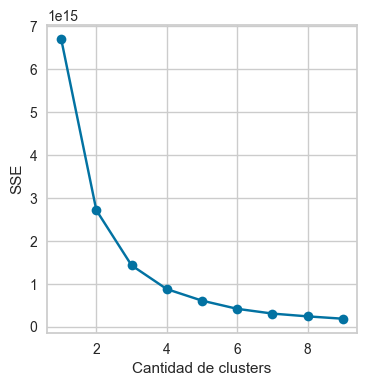

In [8]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(datos_numericos)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(4, 4))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

De aqui vemos que el el "codo" de la funcion esta en 3 clusters. Igualmente podriamos utilizar tambien 4 o 5 clusters para reducir el error aun mas.

Luego, calculamos al silhouette score

In [9]:

#list_k = list(range(2, 6))

#for n_clusters in list_k:
#    clusterer = KMeans(n_clusters=n_clusters)
#    preds = clusterer.fit_predict(datos_numericos)
#
#    score = silhouette_score (datos_numericos , preds)
#    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

#For n_clusters =2 silhouette score is 0.8860751886850246
#For n_clusters =3 silhouette score is 0.7787797603364277
#For n_clusters =4 silhouette score is 0.7049445258428725
#For n_clusters =5 silhouette score is 0.6546668772021881


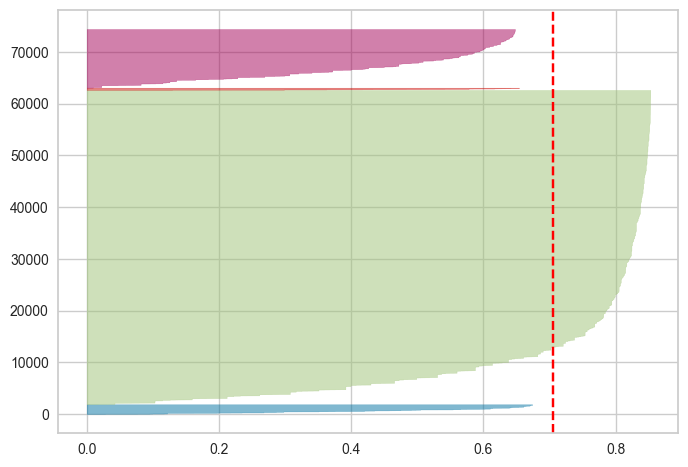

In [19]:
model = KMeans(4, random_state=0)

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(datos_numericos)
plt.show()

De aqui concluimos que para el silhouette method el numero optimo de clusters es 2. 

Comienzo analisis de grupos 

In [ ]:
print(datos_numericos.columns)

Index(['latitud', 'longitud', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price'],
      dtype='object')


#### ANALISIS DE GRUPOS

In [24]:
kmeans = KMeans(n_clusters=4)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento
kmeans.fit(datos_numericos) #Entrenamos el algoritmo para que aprenda cómo agrupar
predict = kmeans.predict(datos_numericos)

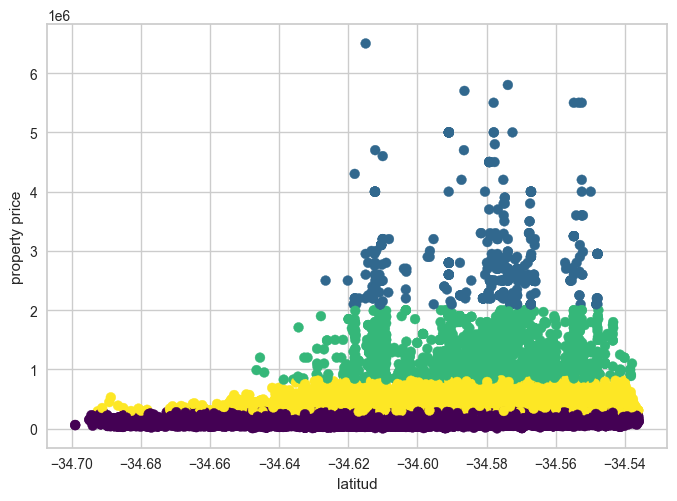

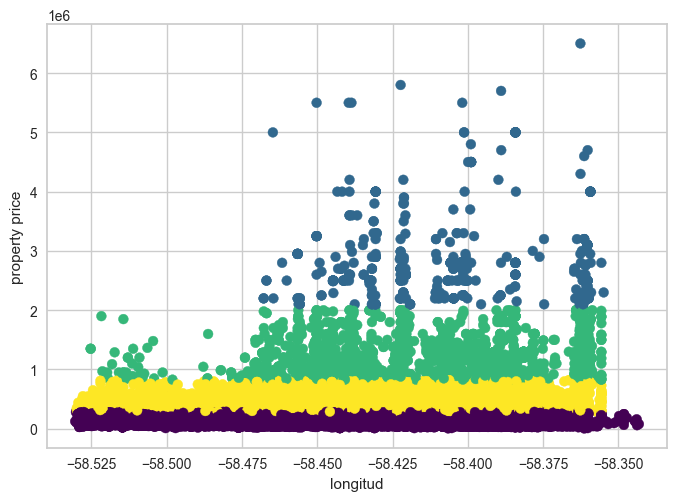

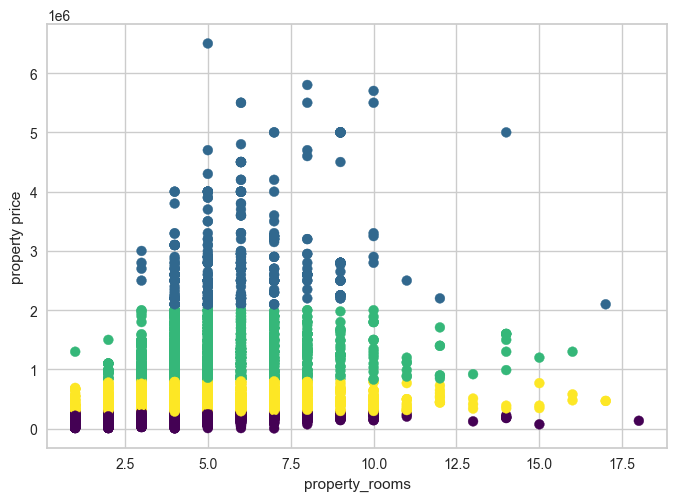

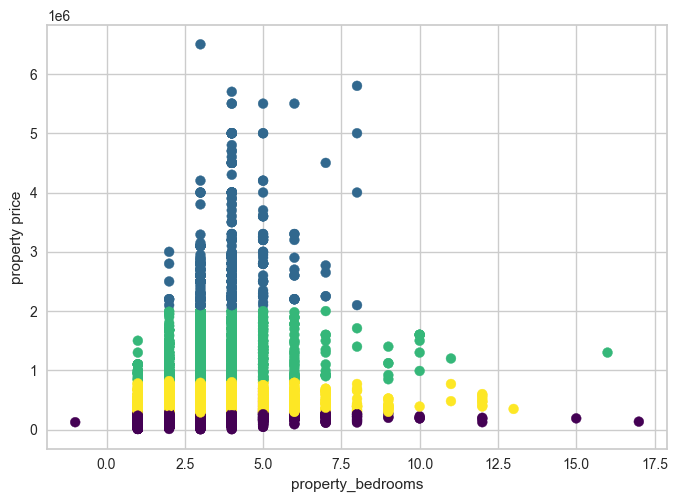

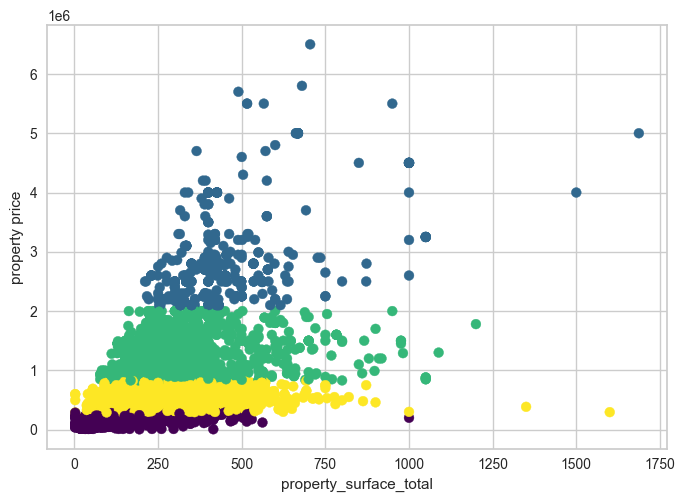

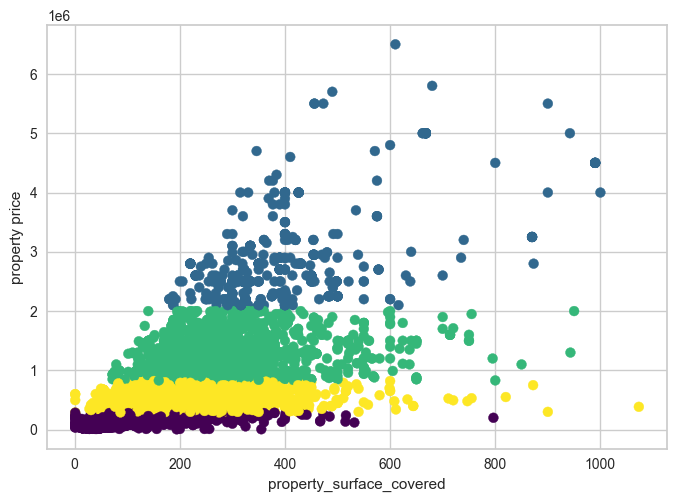

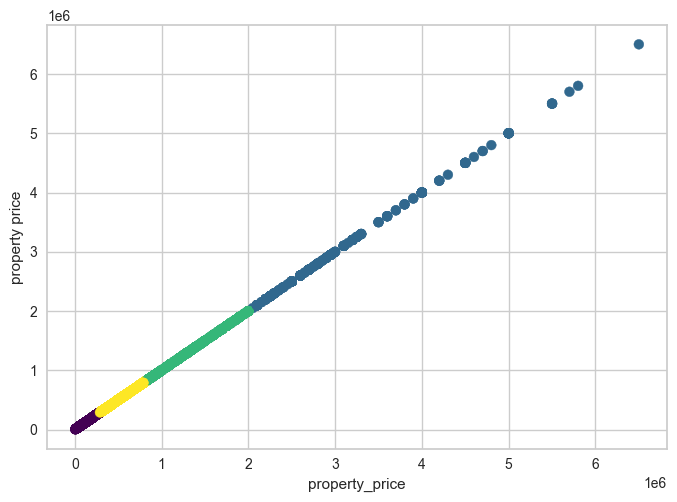

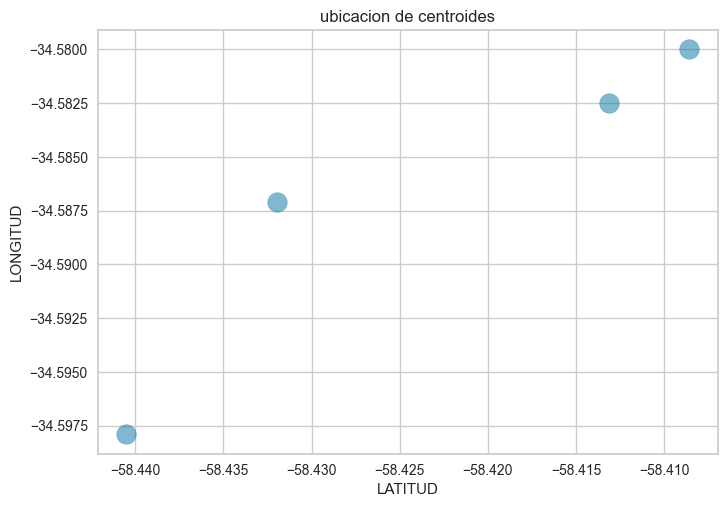

In [70]:
#for i in predict:
#    print(i)
for i in datos_numericos.columns:
    plt.scatter(datos_numericos.loc[:,i], datos_numericos.loc[:,'property_price'], c=predict, s=50, cmap='viridis' )
    plt.xlabel(i)
    plt.ylabel('property price')
    plt.show()

#for i in datos_numericos.columns:
#    for j in datos_numericos.columns:
#        plt.scatter(datos_numericos.loc[:, i], datos_numericos.loc[:, j], c=predict, s=50, cmap='viridis')
#        plt.show()

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], s=200, alpha=0.5)
plt.title('ubicacion de centroides')
plt.xlabel('LATITUD')
plt.ylabel('LONGITUD')
plt.show()

In [25]:
con_predict = datos_numericos.copy()
con_predict['predict'] = predict

#pairplot_cluster = sns.pairplot(con_predict, hue='predict' )
#pairplot_fig = sns.pairplot(viviendas_caba_train, hue='property_type').figure
#pairplot_fig.savefig('./Figures/paiplot')

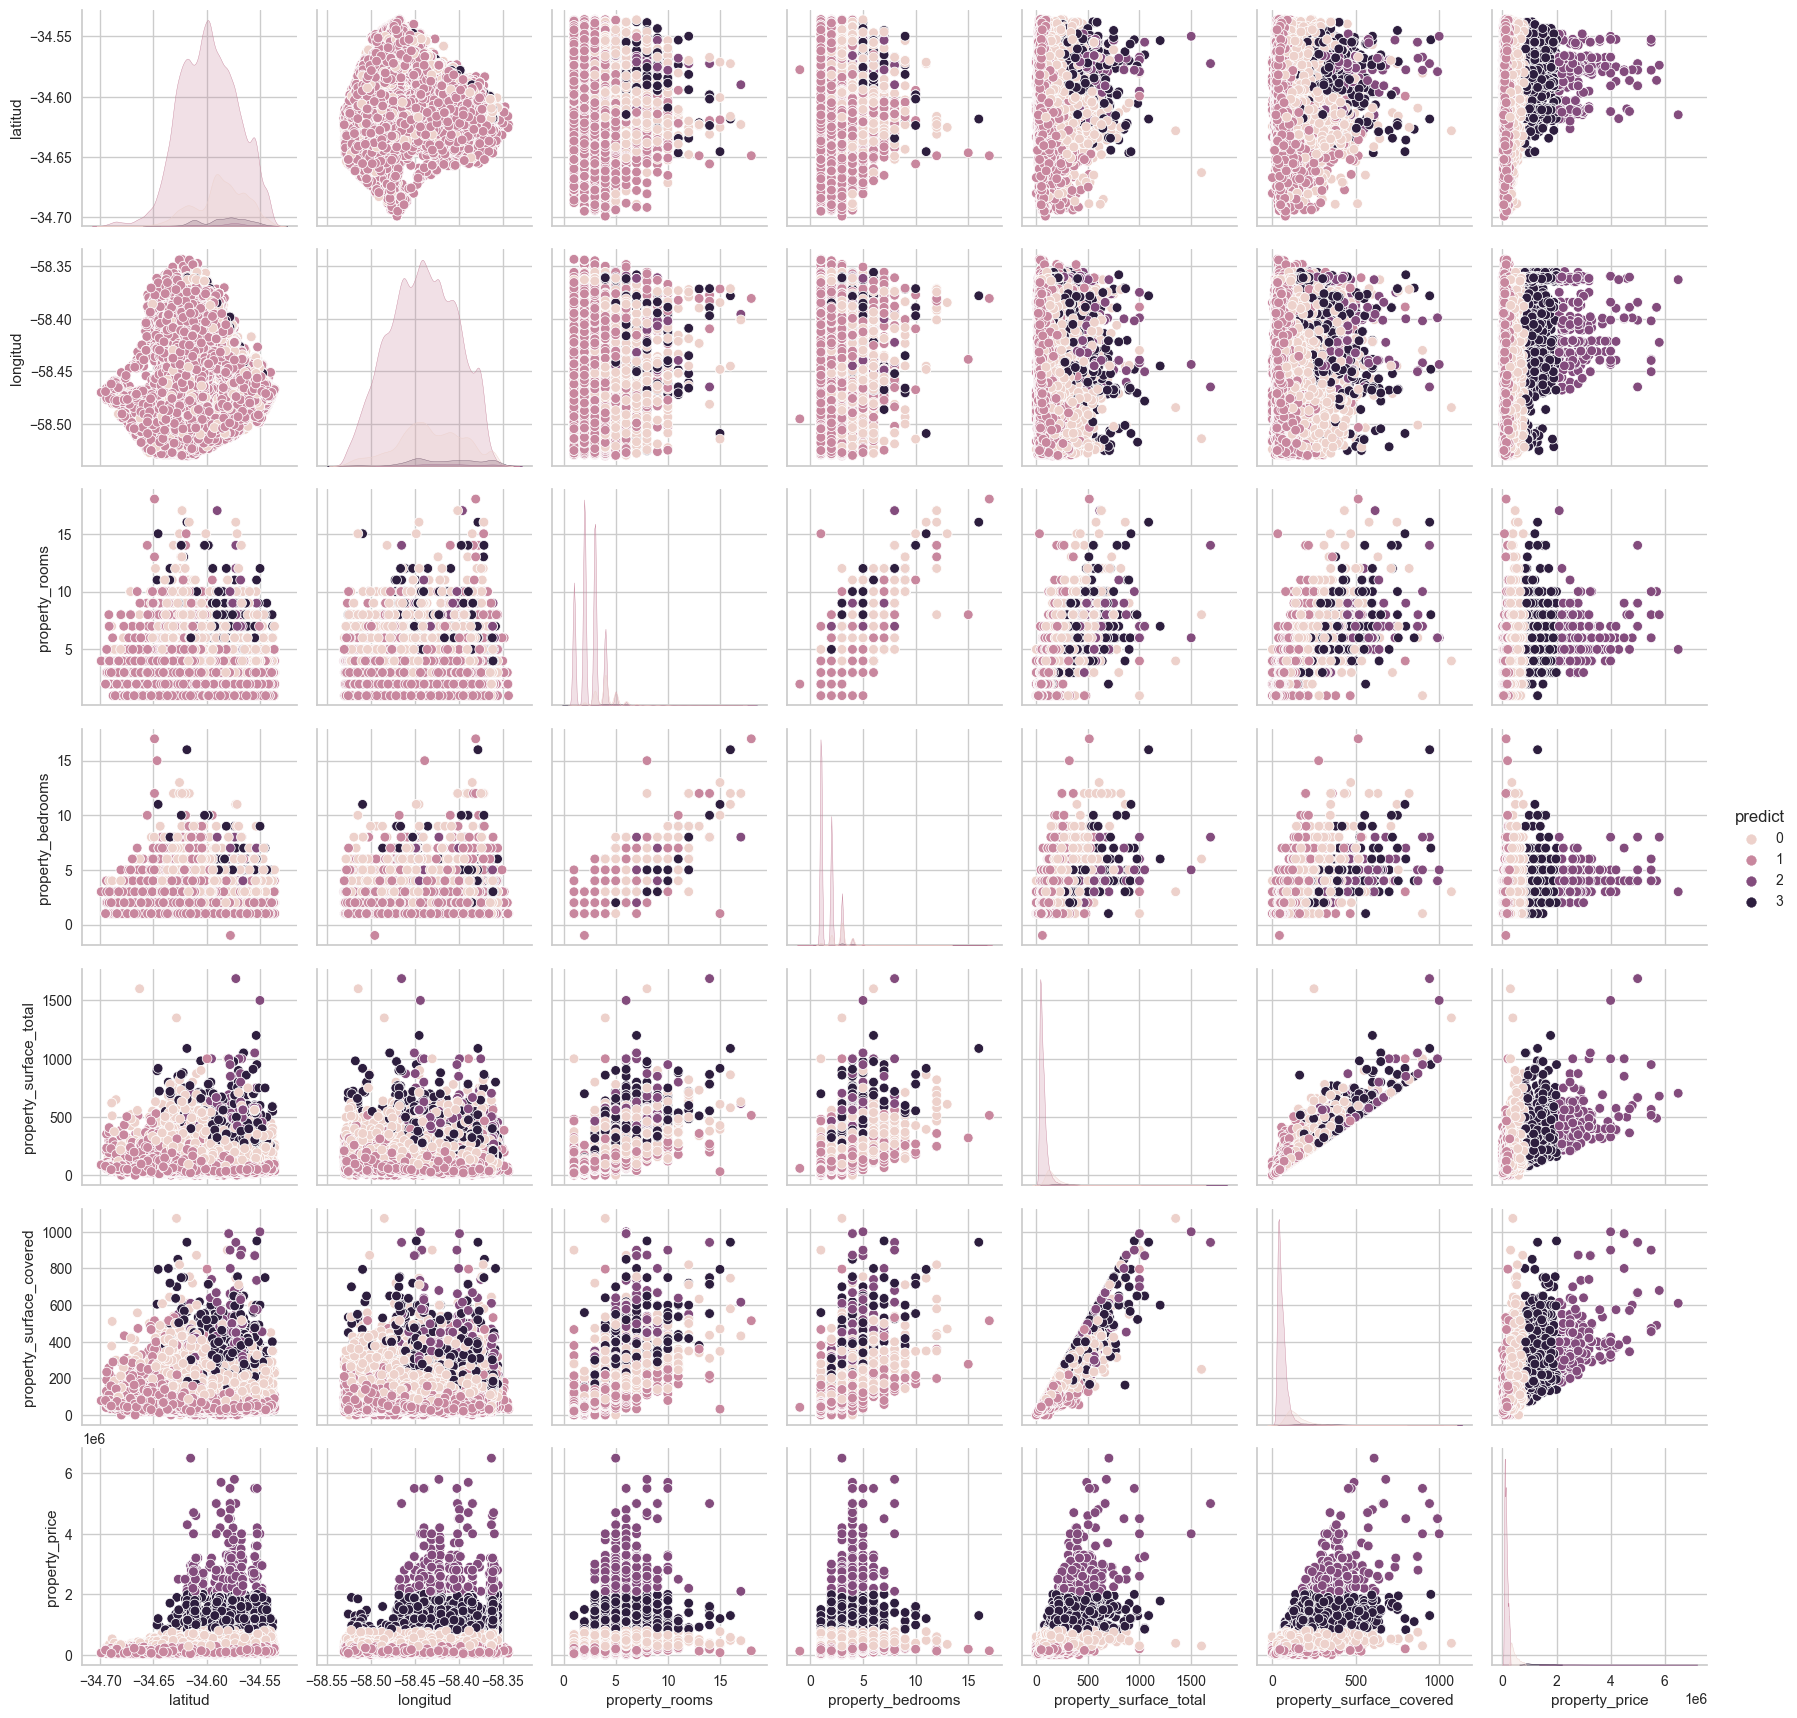

In [12]:
from IPython.display import Image
Image(filename = './Figures/pairplot_cluster.png', width=1800, height=1720)

In [74]:
cluster_0 = con_predict[con_predict.predict == 0]
cluster_1 = con_predict[con_predict.predict == 1]
cluster_2 = con_predict[con_predict.predict == 2]
cluster_3 = con_predict[con_predict.predict == 3]


#ESTO Y LOS 4 DE ABAJO HAY QUE BORRARLOS
#al final capaz no, no?

#pienso

In [75]:
print(cluster_0.shape)
cluster_0.describe()

(60740, 9)


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,predict
count,60740.000000,60740.000000,60740.000000,60740.000000,60740.000000,60740.000000,60740.000000,60740.0
mean,-34.597911,-58.440546,2.471716,1.642641,66.995837,57.329546,135663.603589,0.0
std,0.026667,0.037567,1.103245,0.831190,39.840724,29.711891,58961.973227,0.0
min,-34.698989,-58.530391,1.000000,-1.000000,2.252427,1.000000,5000.000000,0.0
25%,-34.617446,-58.468228,2.000000,1.000000,42.000000,38.000000,89000.000000,0.0
50%,-34.598288,-58.440339,2.000000,1.000000,57.000000,50.000000,125000.000000,0.0
75%,-34.578700,-58.411674,3.000000,2.000000,79.000000,69.000000,173857.500000,0.0
max,-34.535964,-58.343239,18.000000,17.000000,1000.000000,796.465446,288000.000000,0.0


In [76]:
print(cluster_1.shape)
cluster_1.describe()

(428, 9)


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,predict
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,4.280000e+02,428.0
mean,-34.580002,-58.408568,6.002336,3.857477,460.624257,413.004298,2.874943e+06,1.0
std,0.018823,0.030401,1.752213,0.953615,181.405171,155.017740,7.933949e+05,0.0
min,-34.626565,-58.467816,3.000000,2.000000,211.000000,180.000000,2.050000e+06,1.0
25%,-34.590923,-58.431863,5.000000,3.000000,350.000000,320.000000,2.300000e+06,1.0
50%,-34.576231,-58.409712,6.000000,4.000000,421.500000,390.000000,2.600000e+06,1.0
75%,-34.567198,-58.384214,7.000000,4.000000,500.000000,455.000000,3.099250e+06,1.0
max,-34.547911,-58.354919,17.000000,8.000000,1687.000000,1000.000000,6.500000e+06,1.0


In [77]:
print(cluster_2.shape)
cluster_2.describe()

(1879, 9)


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,predict
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1.879000e+03,1879.0
mean,-34.582514,-58.413103,5.191591,3.474188,299.344983,266.456473,1.208119e+06,2.0
std,0.020419,0.036740,1.743545,1.166742,138.670506,111.922673,3.152219e+05,0.0
min,-34.646550,-58.525256,1.000000,1.000000,77.000000,72.000000,8.250000e+05,2.0
25%,-34.593580,-58.445597,4.000000,3.000000,206.500000,186.500000,9.490000e+05,2.0
50%,-34.579630,-58.409948,5.000000,3.000000,275.000000,245.000000,1.150000e+06,2.0
75%,-34.566290,-58.384201,6.000000,4.000000,348.608667,310.000000,1.400000e+06,2.0
max,-34.537936,-58.355689,16.000000,16.000000,1200.000000,950.000000,2.000000e+06,2.0


In [78]:
print(cluster_3.shape)
cluster_3.describe()

(11324, 9)


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,predict
count,11324.000000,11324.000000,11324.000000,11324.000000,11324.000000,11324.000000,11324.000000,11324.0
mean,-34.587109,-58.431950,4.182091,2.947015,170.912783,144.393603,440898.750265,3.0
std,0.023741,0.037949,1.298731,1.016607,90.225154,69.785534,134620.922226,0.0
min,-34.692474,-58.529931,1.000000,1.000000,2.252427,1.000000,288800.000000,3.0
25%,-34.599921,-58.456888,3.000000,2.000000,113.000000,100.000000,330000.000000,3.0
50%,-34.585893,-58.434378,4.000000,3.000000,148.000000,129.000000,398000.000000,3.0
75%,-34.569077,-58.404287,5.000000,3.000000,201.000000,170.000000,520000.000000,3.0
max,-34.536144,-58.355689,17.000000,13.000000,1600.000000,1073.120423,820000.000000,3.0



esto tiene que ser la conclusion del analisis de sobre que caracteristica se formaron los clusters (ahora incompleta y desprolija)

Viendo el analisis realizado, 'sospecho' que los clusters fueron formados segun el precio, ya que en los pairplot es donde se ve una diferencia mas acentuada, y luego, se ve que el cluster que tiene menos viviendas tiene los precios mas altos de todos, lo que tiene sentido siendo que hay mas viviendas de precio promedio que tan alto como en ese cluster.

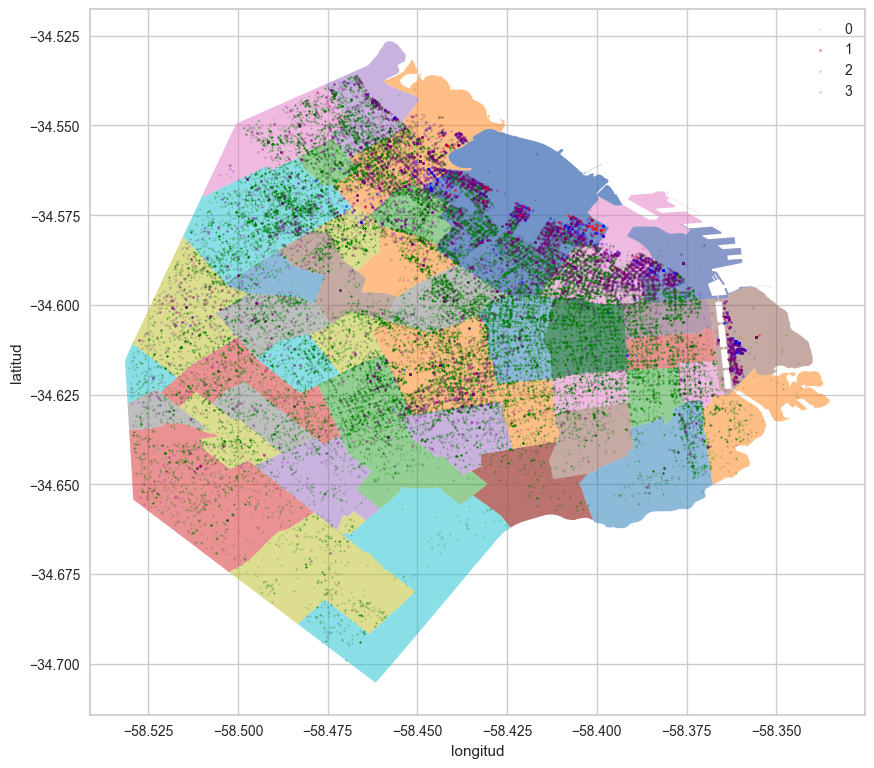

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
con_predict = gp.GeoDataFrame(con_predict, geometry=gp.points_from_xy(con_predict.longitud, con_predict.latitud))
plt.xlabel("longitud")
plt.ylabel("latitud")
con_predict[con_predict.predict == 0].plot(ax=ax, color='green', label='0',alpha=0.2, markersize = 1)
con_predict[con_predict.predict == 1].plot(ax=ax, color='red', label='1',alpha=0.5, markersize = 2)
con_predict[con_predict.predict == 2].plot(ax=ax, color='blue', label='2',alpha=0.2, markersize = 2)
con_predict[con_predict.predict == 3].plot(ax=ax, color='purple', label='3',alpha=0.2, markersize = 2)
plt.legend()
plt.show()

#### REPETIR ANALISIS CON 3 CLUSTERS